# Convolutional neural networks

Convolutional neural networks (CNNs or convnets) are a type of architecture based on how the visual cortex works. The main principles that improve performance of CNNs over feedforward nets are:
  
  - Sparse connectivity: in CNNs, a feature at any given layer only depends on a subset of the input of that layer, whereas in feedforward nets each hidden unit depends on the entire layer input
  - Parameter sharing: at each layer, we learn several small filters (or convolution kernels) and apply them to the entire layer input
  - Equivariant representations: a filter that detects e.g. an eye can detect an eye everywhere on an image (translation invariance)

CNNs are often used for 2D or 3D data (such as grayscale or RGB images), but can also be applied to several other types of input, such as:

  - 1D data: time-series, raw waveforms
  - 2D data: grayscale images, spectrograms
  - 3D data: RGB images, multichannel spectrograms

CNNs are mostly used for classification (and in fact are part of most state-of-the-art computer vision applications), but also appear as an important part of several generative models for image data.

![](cnn.png)



## Convolutional layer

The convolution operation for a 2D filter is given by the following equation:

$$
S(i, j) = (I ∗ K)(i, j) =\sum_m\sum_n I(m, n)~K(i − m, j − n)
$$

<img src="conv.gif" width=350px>

- Blue: input $I$
- Gray: filter $K$
- Green: output $S$
- $i, j$ are the indices for rows and columns
- "Transparent": zero-padding


(image from [Dumoulin & Visin, "A guide to convolution arithmetic for deep learning"](https://github.com/vdumoulin/conv_arithmetic), under the MIT License)

Note that the amount of zero-padding, filter and input dimensions affect the output dimensions. 

## Pooling

- Acts as downsampling: replaces the output of a convolution layer with a summary statistic of the nearby outputs. 
- Reminder: pooling throws away information, so use it wisely!
- Usual pooling strategy for 2D data: 2 x 2 max-pooling.

## Output layer

Since convolutional layers have outputs with larger dimensionality, we often cannot use one as the output layer of a DNN (unless we are predicting an image or image patch). Common practice is to flatten the last convolutional layer of a CNN and then use one or more fully-connected layers to project the data into a space with the correct number of dimensions.

Keras has a `Flatten` layer (in `keras.layers.Flatten`) which can be used to perform this operation. Other reshape operations can be performed with the more general `Reshape` layer.

## Hyperparameters in CNNs

CNNs have even more hyperparameters than feedforward nets, which often have to be optimized to achieve good performance.

  - Number of filters per layer: usually, less filters in lower layers, more filters in higher layers (less basic forms than complex forms)
  - Filter shape: current "trend" for computer vision applications is to use very small filters (3x3).
  - Max-pooling shape (or downsampling rate): typically, 2 x 2 max-pooling applied after every other convolutional layer.

## Mandatory MNIST example

Here is a code sample for training a CNN on the same MNIST data we have seen in the tutorial introduction. Even though it has less parameters than the feedforward model shown in the intro, it achieves higher accuracy than that model in a smaller number of epochs.

Note that typical CNNs for natural images have a much larger number of convolutional layers than this model. [VGG-19](https://gist.github.com/baraldilorenzo/8d096f48a1be4a2d660d), which was the model that won the ImageNet Large Scale Visual Recognition Challenge in 2014, has 19 convolutional layers(!). 

In [1]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import numpy as np
np.random.seed(42)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

batch_size = 128
nb_classes = 10
nb_epoch = 10

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.summary()

Using Theano backend.
Using gpu device 0: Quadro K2000M (CNMeM is disabled, cuDNN 5005)


X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 26, 26)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 26, 26)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 24, 24)    9248        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 32, 24, 24)    0           convolution2d_2[0][0]            
__________________

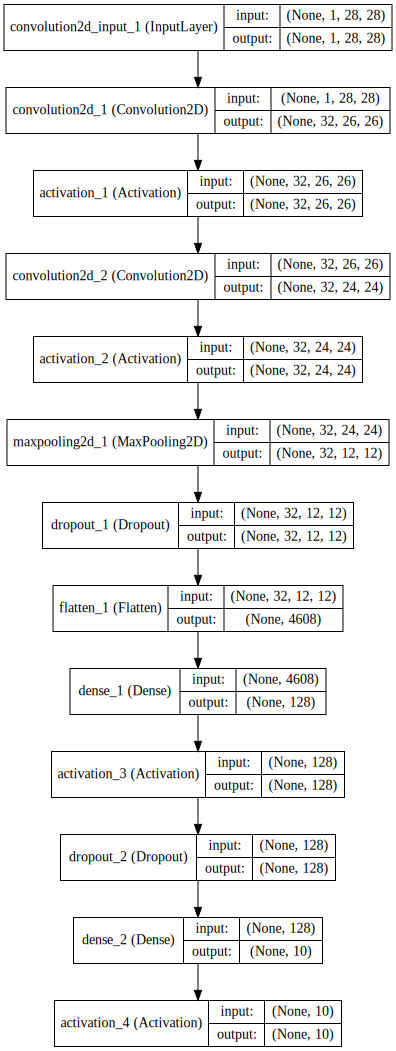

In [2]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [3]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 50s - loss: 0.2592 - acc: 0.9221 - val_loss: 0.0676 - val_acc: 0.9797
Epoch 2/10
60000/60000 [==============================] - 50s - loss: 0.0969 - acc: 0.9714 - val_loss: 0.0436 - val_acc: 0.9861
Epoch 3/10
60000/60000 [==============================] - 50s - loss: 0.0714 - acc: 0.9788 - val_loss: 0.0414 - val_acc: 0.9871
Epoch 4/10
60000/60000 [==============================] - 50s - loss: 0.0604 - acc: 0.9820 - val_loss: 0.0349 - val_acc: 0.9885
Epoch 5/10
60000/60000 [==============================] - 50s - loss: 0.0542 - acc: 0.9840 - val_loss: 0.0358 - val_acc: 0.9888
Epoch 6/10
60000/60000 [==============================] - 50s - loss: 0.0499 - acc: 0.9856 - val_loss: 0.0357 - val_acc: 0.9889
Epoch 7/10
60000/60000 [==============================] - 50s - loss: 0.0467 - acc: 0.9858 - val_loss: 0.0376 - val_acc: 0.9890
Epoch 8/10
60000/60000 [==============================

## More info/References

- [CS231n - Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)
- [Chapter 7 of the Deep Learning Book](http://www.deeplearningbook.org/contents/convnets.html)